In [4]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import pickle
root = '../dataset/hi'
root_soh = '../dataset/soh_charge'
root_model = '../model'


In [5]:

def load_and_process(root, root_soh, dataset):
    hiv = pd.read_csv(f'{root}/hiv-charge-CS2_{dataset}.csv')
    soh = pd.read_csv(f'{root_soh}/Csoh-CS2_{dataset}.csv')

    # Mantieni solo le colonne da hiv e soh
    df = pd.merge(hiv, soh, how="right", on="cycle")[["cycle", "hi_v", "SOH"]]
    df = df.drop(columns=["cycle"])
    df_hiv = df[["hi_v"]]
    df_soh = df[["SOH"]]
    return df_hiv.values, df_soh.values

# Carica e processa i dataset
df_33_hiv, df_33_soh = load_and_process(root, root_soh, 33)
df_35_hiv, df_35_soh = load_and_process(root, root_soh, 35)
df_37_hiv, df_37_soh = load_and_process(root, root_soh, 37)
df_36_hiv, df_36_soh = load_and_process(root, root_soh, 36)
df_38_hiv, df_38_soh = load_and_process(root, root_soh, 38)


In [6]:
seq_length = 10

def split_sequence(data, seq_length, train=False):
    seq = []   
    for j in data:
        for i in range(len(j) - seq_length):
            if train is True:
                seq.append(j[i:i+seq_length])
            else:
                seq.append(j[i+seq_length-1])
    if train:
        return np.array(seq)
    else:
        return np.array(seq)

In [7]:
print(df_36_soh.shape, df_38_soh.shape)

(827, 1) (904, 1)


In [8]:
# Create sequences for training set

X_train = split_sequence([df_36_hiv, df_38_hiv], seq_length, train=True)
y_train = split_sequence([df_36_soh, df_38_soh], seq_length)

# Calculate mean and std for normalization
mean = X_train.mean()
std = X_train.std()

# Standardize train data
X_train = (X_train - mean) / std

# Shuffle the sequences
perms = np.random.permutation(len(X_train))
X_train = X_train[perms]
y_train = y_train[perms]


print(X_train.shape, y_train.shape)

(1711, 10, 1) (1711, 1)


In [9]:
X_train.shape

(1711, 10, 1)

In [10]:
# load the data
trainLen = len(X_train)
# testLen = len(X_test)
initLen = 100
print(trainLen, initLen)

1711 100


In [11]:
class ESN:
    def __init__(
            self,
            inSize= 1,
            outSize = 1,
            resSize = 100,
            a = 1,
            seed = 42,
            spectral_radius = .9,
            reg = 1e-4
            ):
        self.inSize = inSize
        self.outSize = outSize
        self.resSize = resSize
        self.a = a
        self.reg = reg
        np.random.seed(seed)
        self.Win = (np.random.rand(self.resSize,inSize) - 0.5) * 2
        self.res_bias = (np.random.rand(self.resSize,1) - 0.5) * 2
        self.W = (np.random.rand(resSize,resSize) - 0.5) * 2
        rhoW = np.max(np.abs(np.linalg.eigvals(self.W)))
        self.W *= spectral_radius / rhoW
        

    def res_forward(self, X_train):
        # H = []
        n_example = X_train.shape[0]
        # for j in range(n_example):
        h = np.zeros((self.resSize, n_example))
        res_bias = np.repeat(self.res_bias, n_example, axis=1)
        for t in range(X_train.shape[1]):
            # (n_example, inSize)
            x = X_train[:,t]
            # (resSize, n_example) = (resSize, inSize) * (inSize, n_example) + (resSize, resSize) * (resSize, n_example) + (resSize, n_example) 
            h_temp =  np.tanh(self.Win @ x.T + self.W @ h + res_bias)
            #(resSize, n_example) = (resSize, n_example) + (resSize, n_example) 
            h = (1-self.a)*h + self.a*h_temp
        # H.append(h.T)
        # (n_example, resSize)
        return h.T
    
    def fit(self, X_train, y_train):
        H = self.res_forward(X_train)
        Y = y_train
        I = np.eye(self.resSize)
        # (resSize, outSize) = ((resSize, n_example) * (n_example, resSize) + (resSize, resSize)) * (resSize, n_example) * (n_example, outSize)
        self.Wout = np.linalg.inv( H.T @ H + self.reg*I) @ H.T @ Y 
        
    def predict(self, X_test):
        H = self.res_forward(X_test)
        #(n_examples, outSize) = (n_example, resSize) *  (resSize, outSize)
        o = H @ self.Wout
        return o
    


In [12]:
model = ESN(a = 0.3)
model.fit(X_train = X_train, y_train=y_train)

In [13]:
# save the model
with open(f'{root_model}/ESN.pkl', 'wb') as f:
    pickle.dump(model, f)

In [14]:
# Change test df to plot different samples
file_number = 33
file_hiv = globals()[f'df_{file_number}_hiv']
file_soh = globals()[f'df_{file_number}_soh']

# Create sequences for testing set
X_test = split_sequence([df_35_hiv], seq_length, train = True)
y_test = split_sequence([df_35_soh], seq_length)

# Normalize the test data using the mean and std from training data
X_test = (X_test - mean) / std

(787, 1) 0.7532937452021166 0.8941796829465746


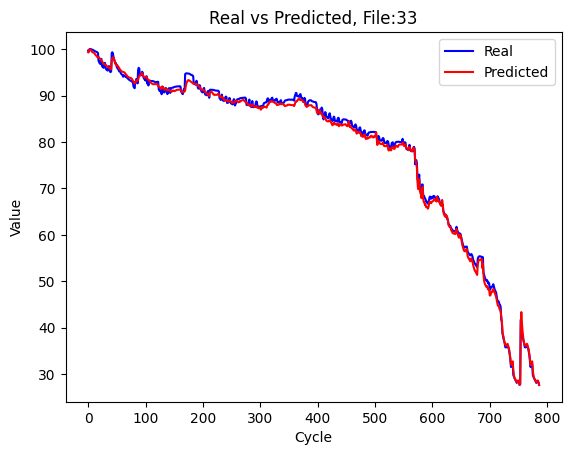

In [15]:
# Predici i valori sul dataset di test
y_pred = model.predict(X_test=X_test)
mae = np.abs(y_pred - y_test).mean()
rmse = np.sqrt(np.power((y_pred - y_test),2).mean())
print(y_pred.shape, mae*100, rmse*100)
plt.plot((y_test/1.1)*100, label='Real', color='blue')
plt.plot((y_pred/1.1)*100, label='Predicted', color='red')
plt.title(f'Real vs Predicted, File:{file_number}')
plt.xlabel('Cycle')
plt.ylabel('Value')
plt.legend()
plt.show()